# **Distance Predictor Part UseCase**
Author: Declan Costello

Date: 10/8/2023

## **Part Use Case**

Here I look for use cases of the Voting Regressor Model

## **Table of Context**

1. Installation
2. Loading Model
3. Data Import
4. Train Test Split
5. Stratify
6. Input
7. Use Cases

**Installation**
- The following installs the necessary packages

In [1]:
import bz2
import random
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import simps
from sklearn.model_selection import train_test_split

In [2]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

**Loading Model**

In [3]:
#load saved compressed model
with bz2.BZ2File('compressed_9_model.joblib.bz2', 'rb') as f:
    lo_mo = joblib.load(f)

**Data Import**

In [4]:
data = pd.read_csv('FE_data.csv')

**Train Test Split**

In [5]:
feature_cols = ['launch_angle','launch_speed','pfx_x','pfx_z',"release_speed","home_team","stand","p_throws","fav_platoon_split_for_batter","grouped_pitch_type", "domed", "spray_angle",'is_barrel','Pop','pull_percent']
X = data.loc[:, feature_cols]

target_cols = ['hit_distance_sc']
y = data.loc[:, target_cols]

**Stratify**

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.95, test_size=0.05,random_state=0,stratify = X[['home_team',"stand",'grouped_pitch_type']])

**Input**

In [7]:
#I want a sample input that us a barreled ball within a domed stadium
final_vars = X_valid.loc[X_valid['is_barrel']==1]
final_vars = final_vars.loc[final_vars['domed']==0]

#use first sample found and transpose it
f = final_vars.iloc[0]
final_vars = f.to_frame().T
final_vars['pfx_x'] = 0
final_vars

,launch_angle,launch_speed,pfx_x,pfx_z,release_speed,home_team,stand,p_throws,fav_platoon_split_for_batter,grouped_pitch_type,domed,spray_angle,is_barrel,Pop,pull_percent
31639,28.0,108.5,0,0.44,90.9,ATL,L,R,Yes,breaking,0,12.024571,1,17.6,0.589679


# **Use Case #1**

In [8]:
#I want a sample input that us a barreled ball within a domed stadium
final_vars = X_valid.loc[X_valid['is_barrel']==1]
final_vars = final_vars.loc[final_vars['domed']==0]

#use first sample found and transpose it
f = final_vars.iloc[0]
final_vars = f.to_frame().T
final_vars['pfx_x'] = 0
final_vars

def plot_stadium_expected_distance(speed, team1, team2):
    # Define the launch angles
    list_of_launch_angles = [round(x * 0.1, 1) for x in range(0, 601)]
        
    final_vars['launch_speed'] = speed

    # Calculate distances for team1 and team2
    team1_distances = []
    team2_distances = []

    for i in list_of_launch_angles:
        final_vars['launch_angle'] = i
        final_vars['home_team'] = str(team1)
        preds = lo_mo.predict(final_vars)
        team1_distances.append(preds[0])

        final_vars['home_team'] = str(team2)
        preds = lo_mo.predict(final_vars)
        team2_distances.append(preds[0])

    # Calculate apex points for team1 and team2
    apex_x1 = list_of_launch_angles[np.argmax(team1_distances)]
    apex_y1 = max(team1_distances)

    apex_x2 = list_of_launch_angles[np.argmax(team2_distances)]
    apex_y2 = max(team2_distances)

    # Calculate the difference in max distances
    distance_difference = abs(apex_y1 - apex_y2)

    # Calculate the area between the curves using Simpson's rule (numerical integration)
    area_between_curves = simps(np.abs(np.array(team1_distances) - np.array(team2_distances)), list_of_launch_angles)

    # Generate random colors for team1 and team2
    team1_color = "#" + "".join(random.choice("0123456789ABCDEF") for _ in range(6))
    team2_color = "#" + "".join(random.choice("0123456789ABCDEF") for _ in range(6))

    # Create a Bokeh figure
    p = figure(width=1000, height=500, title=f'{speed} MPH Exit Velocity', x_axis_label='Launch Angle (degrees)', y_axis_label='Distance (feet)')

    # Plot the lines for team1 and team2 with random colors
    p.line(list_of_launch_angles, team1_distances, line_width=2, color=team1_color)
    p.line(list_of_launch_angles, team2_distances, line_width=2, color=team2_color)

    # Add vertical lines at the apex points with labels
    p.line([apex_x1, apex_x1], [0, apex_y1], line_width=2, color=team1_color, line_dash="dashed")
    p.line([apex_x2, apex_x2], [0, apex_y2], line_width=2, color=team2_color, line_dash="dashed")

    # Add labels to the apex points
    p.text(1, 375, text=[f'{str(team1)} Apex: ({apex_x1:.1f}, {apex_y1:.1f} ft)'], text_font_size="12pt", text_color=team1_color)
    p.text(1, 360, text=[f'{str(team2)} Apex: ({apex_x2:.1f}, {apex_y2:.1f} ft)'], text_font_size="12pt", text_color=team2_color)
    p.text(1, 345, text=[f'Max Distance Difference: {distance_difference:.2f} ft'], text_font_size="12pt", text_color=team1_color)
    p.text(1, 330, text=[f'Area Between Curves: {area_between_curves:.2f} ft'], text_font_size="12pt", text_color=team2_color)


    # Fill the area between the curves
    p.varea(x=list_of_launch_angles, y1=team1_distances, y2=team2_distances, color='gray', alpha=0.3)

    # Show the plot with legend
    p.x_range.start = 0
    p.x_range.end = 60
    p.y_range.start = 0

    show(p)


plot_stadium_expected_distance(97, 'COL', 'CHC')

# **Use Case #2**

In [9]:
def max_las_for_each_ev(team1, team2):

    results_df = pd.DataFrame(columns=['Stadium','EV','LA','Distance'])
    count = 0
    final_vars['home_team'] = str(team1)
    for i in range(80,110):

        final_vars['launch_speed'] = i


        # Define the launch angles
        list_of_launch_angles = [round(x * 0.1, 1) for x in range(0, 601)]

        # Calculate distances for team1 and team2
        team1_distances = []

        for x in list_of_launch_angles:
            final_vars['launch_angle'] = x
            preds = lo_mo.predict(final_vars)
            team1_distances.append(preds[0])

        # Calculate apex points for team1 and team2
        apex_x1 = list_of_launch_angles[np.argmax(team1_distances)]
        apex_y1 = max(team1_distances)

        #print('for an EV of ' + str(i) + ', the best LA is ' + str(apex_x1) + ' for a distance of ' + str(apex_y1))
        results_df.loc[count] = [str(team1),i,apex_x1,apex_y1]
        count = count +1  


    final_vars['home_team'] = str(team2)
    team1_distances = []
    for i in range(80,110):

        final_vars['launch_speed'] = i

        # Define the launch angles
        list_of_launch_angles = [round(x * 0.1, 1) for x in range(0, 601)]

        # Calculate distances for team1 and team2
        team1_distances = []

        for x in list_of_launch_angles:
            final_vars['launch_angle'] = x
            preds = lo_mo.predict(final_vars)
            team1_distances.append(preds[0])

        # Calculate apex points for team1 and team2
        apex_x1 = list_of_launch_angles[np.argmax(team1_distances)]
        apex_y1 = max(team1_distances)

        #print('for an EV of ' + str(i) + ', the best LA is ' + str(apex_x1) + ' for a distance of ' + str(apex_y1))
        results_df.loc[count] = [str(team2),i,apex_x1,apex_y1]
        count = count +1

    return results_df

l = max_las_for_each_ev('CHC', 'COL')

results_df = l.sort_values('Distance', ascending=False)

def color_recommend(value):
    if value == 'COL':
        color = 'skyblue'
    elif value == 'CHC':
        color = 'lightgreen'
    else:
        return
    return f'background-color: {color}'


(
    results_df.style.applymap(color_recommend, subset=['Stadium'])\
                .format({"LA": '{:.1f}'})\
                .hide_index()\
                .background_gradient(cmap='Blues')
)

/var/folders/vc/prq7ffv51gl630xh6bmjgj700000gp/T/ipykernel_48912/1887016776.py:75: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  .hide_index()\


Stadium,EV,LA,Distance
COL,109,28.8,433.599254
COL,108,28.9,433.028333
COL,107,29.1,430.898031
COL,106,29.1,428.750187
COL,105,29.2,427.465805
CHC,109,28.2,420.311049
CHC,108,28.6,419.649855
COL,104,29.3,418.602194
COL,103,29.4,417.125350
CHC,107,28.5,416.602346


# **Use Case #3**

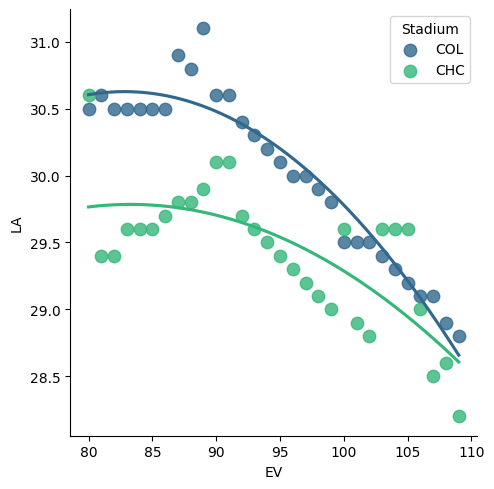

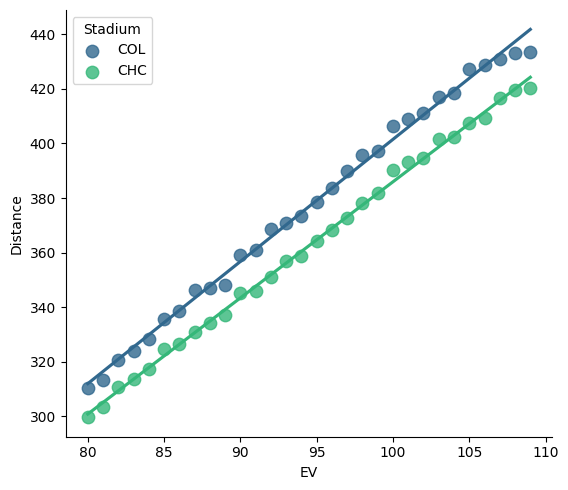

In [10]:
# First lmplot
ax = sns.lmplot(data=results_df, 
           x="EV", 
           y="LA",  
           hue="Stadium", 
           order=2,
           ci=None,
           palette='viridis',
           scatter_kws={"s": 80})
ax.legend.remove()


plt.legend(title = "Stadium",loc = 'upper right')


# Second lmplot
ax2 = sns.lmplot(data=results_df, 
           x="EV", 
           y="Distance",  
           hue="Stadium", 
           order=1,
           ci=None,
           palette='viridis',
           scatter_kws={"s": 80})
ax2.legend.remove()


plt.legend(title = "Stadium",loc = 'upper left')


# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()
